In [1]:
!pip install catboost scikit-plot

# Original Notebook

In [2]:
import pandas as pd
import numpy as np

import re, math, os



from collections import Counter, defaultdict

from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import catboost as ctb
#import lightgbm as lgb

from sklearn.metrics import accuracy_score, f1_score
from scikitplot.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns

p = lambda x: print(x)

%matplotlib inline

### Download IMDB from IBM Cloud Object Storage

As we did previously e.g. in Lab.I.80, let's collect individual training reviews into a list of chains: one chain per review.
We also collect review labels (positive/negative) for the labels list.

In [3]:
import os, types
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

if os.environ.get('RUNTIME_ENV_LOCATION_TYPE') == 'external':
    endpoint_a205bd0ef67d4e43a20f54571521aa41 = 'https://s3-api.us-geo.objectstorage.softlayer.net'
else:
    endpoint_a205bd0ef67d4e43a20f54571521aa41 = 'https://s3-api.us-geo.objectstorage.service.networklayer.com'

client_a205bd0ef67d4e43a20f54571521aa41 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='3oTQ_GU9OAHXSgCgxR06S1CTzFOR44-4KvNuuoVgBqux',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url=endpoint_a205bd0ef67d4e43a20f54571521aa41)
# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about the possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/
streaming_body_4 = client_a205bd0ef67d4e43a20f54571521aa41.get_object(Bucket='2020l-donotdelete-pr-iya5gjhbhguf6w', Key='aclImdb.zip')['Body']
# add missing __iter__ method so pandas accepts body as file-like object
if not hasattr(streaming_body_4, "__iter__"): streaming_body_4.__iter__ = types.MethodType( __iter__, streaming_body_4 ) 
    
data = streaming_body_4._raw_stream  
with open("imdb.zip", "wb") as outfile:
    # Copy the BytesIO stream to the output file
    outfile.write(data.read())
    
import zipfile
with zipfile.ZipFile('imdb.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

We take the 'train' dataset from the files

In [4]:
imdb_dir = './aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf-8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)
                
# create and load df from lists 'labels' and 'texts'
df = pd.DataFrame(columns=['labels', 'texts'])
df['labels']=labels
df['texts']=texts

df.to_csv('df.csv', index=False)

In [5]:
df = pd.read_csv('df.csv')
df

,labels,texts
0,0,or anyone who was praying for the sight of Al ...
1,0,I entered the theatre intending to pass a plea...
2,0,I really looked forward to this program for tw...
3,0,Such is the dilemma(above) that Debbie must fa...
4,0,Any movie in which Brooke Shields out-acts a F...
...,...,...
24995,1,Riding Giants is a brilliant documentary that ...
24996,1,This show has a few clichés and a few over the...
24997,1,As someone who has seen and followed Hartley's...
24998,1,"I heard a few friends one day saying that ""Sca..."


In [6]:
# mixing
df = df.sample(frac = 1.0, random_state=33)

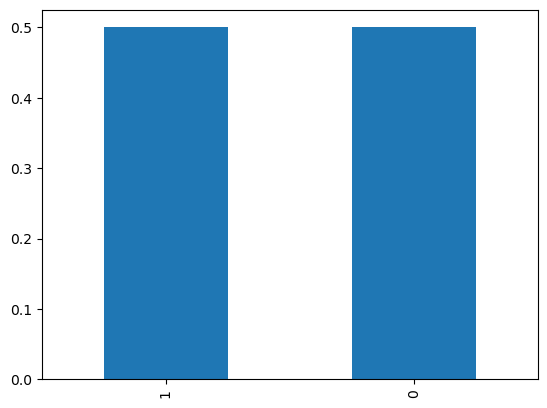

In [7]:
# distribution of labels in the training set
df['labels'].value_counts(normalize=True).plot(kind='bar');

In [8]:
# light normalization
df['texts_norm'] = df['texts'].str.lower()
df

,labels,texts,texts_norm
17797,1,Sudden Impact was overall better than The Enfo...,sudden impact was overall better than the enfo...
6458,0,"""White Noise"" had potential to be one of the m...","""white noise"" had potential to be one of the m..."
14478,1,The first film ever made. Workers streaming fr...,the first film ever made. workers streaming fr...
14825,1,Nobody said movies had to be realistic did the...,nobody said movies had to be realistic did the...
7523,0,This film is very creepy indeed. Unfortunately...,this film is very creepy indeed. unfortunately...
...,...,...,...
57,0,I am generally more willing to be open minded ...,i am generally more willing to be open minded ...
578,0,Let's cut to the chase: this movie is softcore...,let's cut to the chase: this movie is softcore...
5848,0,Race car drivers say that 100 mph seems fast t...,race car drivers say that 100 mph seems fast t...
2439,0,All I could think of while watching this movie...,all i could think of while watching this movie...


In [9]:
test_initial_1 = df.iloc[0]['texts_norm']
test_initial_1

"sudden impact was overall better than the enforcer in my opinion. it was building up to be a great movie, but then i saw the villain(s) and was disappointed.<br /><br />sudden impact was different than the previous installments. the plot went a different direction in this movie, as dirty harry doesn't take as much of a police approach this time around. we also don't see the villain(s) until later, which means less screen time for them, which is better for us all.<br /><br />clint eastwood once again steals the show as dirty harry, enough said. pat hingle was enjoyable as chief jannings, harry's new assigned boss. bradford dillman seemed to change his name to captain briggs here, either way, he wasn't any different. michael currie is decent as lt. donnelly, harry's annoying superior. i personally enjoyed kevyn major howard as hawkins, the young punk who has a vendetta against harry. albert popwell was excellent as horace, harry's buddy. audrie j. neenan was good as ray parkins, a famou

In [10]:
# tokenization
tokens_set = set()
df['texts_norm'].str.split(" ").map(tokens_set.update)

len(tokens_set)

252192

In [11]:
# what are the most frequent tokens? -> Counter(tokens_set).most_common()
cntr = Counter()
df["texts_norm"].str.split(" ").map(cntr.update)
cntr.most_common(n=5)

[('the', 322174),
 ('a', 159949),
 ('and', 158556),
 ('of', 144459),
 ('to', 133965)]

In [12]:
def get_df_topn(text: pd.Series, topn: int, counter_tokens: Counter):

    top_tokens = [x[0] for x in counter_tokens.most_common(n=topn)]

    def check_top_n(sent_tokens):
        return [int(token in sent_tokens) for token in top_tokens]

    df_topn = text.str.split(" ").map(set).map(check_top_n).apply(pd.Series) # .apply: If func returns a Series object the result will be a DataFrame.
    df_topn.columns = top_tokens

    return df_topn

In [13]:
df_top50 = get_df_topn(df["texts_norm"], topn=50, counter_tokens=cntr)

df_top50

,the,a,and,of,to,is,in,i,this,that,...,her,about,it's,some,if,out,what,very,when,more
17797,1,1,1,1,1,1,1,1,1,0,...,0,0,0,1,1,0,0,0,0,0
6458,1,1,1,1,1,1,1,1,1,1,...,0,1,0,0,0,0,0,0,0,0
14478,1,1,1,1,1,1,1,0,1,0,...,0,1,0,1,0,1,0,0,0,0
14825,1,1,1,1,1,0,1,1,1,0,...,0,0,1,0,0,0,0,0,1,0
7523,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,0,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,1,1,1,1,1,1,1,1,1,1,...,1,1,0,0,0,1,1,1,0,1
578,1,1,1,1,1,1,0,0,1,1,...,0,0,1,0,1,1,1,0,0,1
5848,1,1,1,1,1,1,1,1,1,1,...,0,1,0,1,0,1,0,0,0,0
2439,1,1,1,1,1,1,1,1,1,1,...,0,1,1,1,1,1,0,1,1,1


In [14]:
# For how many opinions the category cannot be determined based on the selected number of tokens? 
result = []
for topn in [1, 5, 10, 20, 50, 100]:
    df_topn = get_df_topn( df['texts_norm'], topn=topn, counter_tokens=cntr)
    missing = df_topn[ df_topn.sum(axis=1) == 0 ].shape
    
    result.append((topn, missing))
    print('n={}, missing={}'.format(topn, missing))

n=1, missing=(229, 1)
n=5, missing=(8, 5)
n=10, missing=(4, 10)
n=20, missing=(2, 20)
n=50, missing=(0, 50)
n=100, missing=(0, 100)


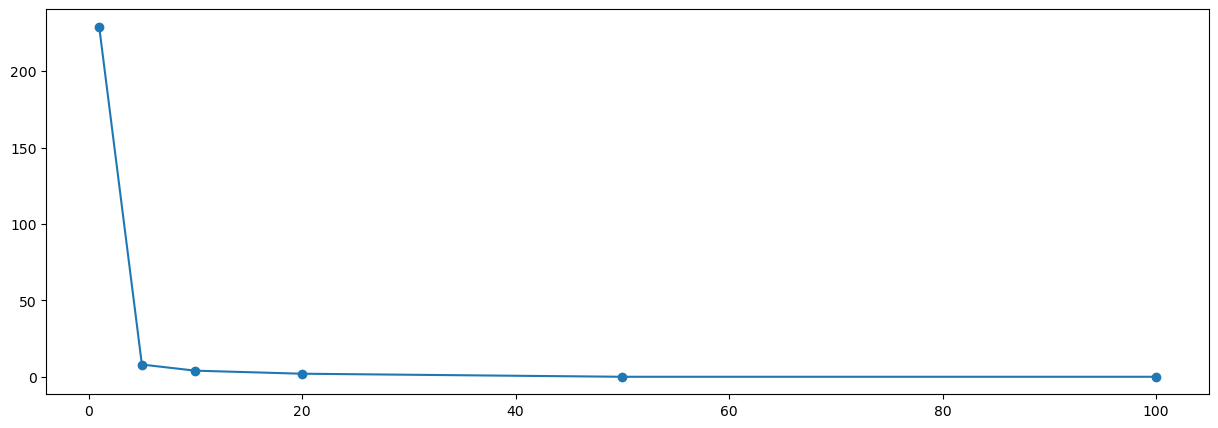

In [15]:
x = [i[0] for i in result]
y = [i[1][0] for i in result]

plt.figure(figsize=(15, 5))
plt.plot( x, y, 'o-' );

## <span style="color:yellow">Introduction to modelling: *bag of words*</span>

### <span style="color:yellow">Approach based on manual tokenization</span>

<span style="color:#ffff00">Check on the test data</span>

In [16]:
imdb_dir = './aclImdb'
test_dir = os.path.join(imdb_dir, 'test')

labels_test = []
texts_test = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf-8')
            texts_test.append(f.read())
            f.close()
            if label_type == 'neg':
                labels_test.append(0)
            else:
                labels_test.append(1)

df_test = pd.DataFrame(columns=['labels', 'texts'])
df_test['labels']=labels_test
df_test['texts']=texts_test
df_test.to_csv('df_test.csv', index=False)

In [17]:
df_test = pd.read_csv('df_test.csv')
df_test

,labels,texts
0,0,"Oh, how I laughed during those first couple of..."
1,0,"Upon renting this, I wasn't expecting to be bl..."
2,0,It's not easy to find Judas Kiss on VHS (it's ...
3,0,There's nothing to say except I want my time b...
4,0,"I'm amazed that ""The Hospital"" has been so wel..."
...,...,...
24995,1,A couple of years before SCREAM spoofed the sl...
24996,1,*BE WARNED OF POSSIBLE SPOILERS*<br /><br />A ...
24997,1,I saw this originally on Channel 4 (UK) and it...
24998,1,"To anyone who is interested, I have managed to..."


In [18]:
df_test = df_test.sample(frac = 1.0, random_state=33)
df_test['texts_norm'] = df_test['texts'].str.lower()

In [19]:
df_test.iloc[:25000]

,labels,texts,texts_norm
17797,1,A film that deserved theatrical release. This ...,a film that deserved theatrical release. this ...
6458,0,What a drawn out painful experience.<br /><br ...,what a drawn out painful experience.<br /><br ...
14478,1,Every American who thinks he or she understand...,every american who thinks he or she understand...
14825,1,I think a person would be well-advised to read...,i think a person would be well-advised to read...
7523,0,"this is horrible film. it is past dumb. first,...","this is horrible film. it is past dumb. first,..."
...,...,...,...
57,0,HOW MANY MOVIES ARE THERE GOING TO BE IN WHICH...,how many movies are there going to be in which...
578,0,Worst pile of drivel to date! Everyone involve...,worst pile of drivel to date! everyone involve...
5848,0,"A heist film with Jean Reno, Matt Damon and La...","a heist film with jean reno, matt damon and la..."
2439,0,"Though a fan of shock and gore, I found this m...","though a fan of shock and gore, i found this m..."


In [20]:
#let's take an example
df_test.iloc[4]['texts_norm']

'this is horrible film. it is past dumb. first, the only thing the twins care about is how they look and what boys like them. they are in 7th grade. not to say i am a prude or anything but it sends the wrong message to girls of all ages. being pretty and popular is not everything. but that is what the twins make it out to be. the plot is even worse. the girl\'s grandpa just happens to be the ambasitor(sp?) to france. he has a co-worker take the girls around paris and they meet two "cute french boys" with motorcycles. they sneek out to meet the boys start to really like them etc.....they meet a supermodel in process and go around paris with total strangers they think are cute. need i say more? this movie may be cute to 8&9 year olds. the twins play ditsy losers that want boyfriends. it makes sends the wrong idea to girls. the film itself is not great either. i don\'t recomend this to anyone. i give passport to paris 2/10'

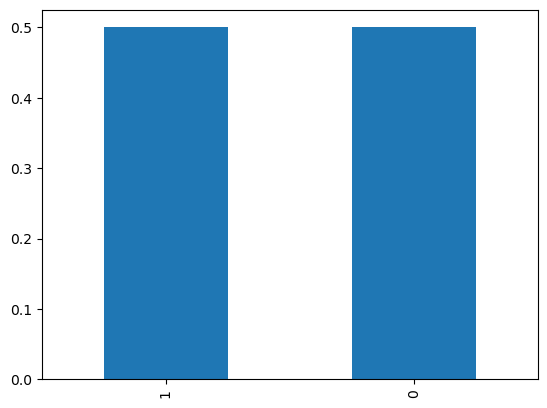

In [21]:
df_test.iloc[:25000]['labels'].value_counts(normalize=True).plot(kind='bar');

In [22]:
y = df_test.iloc[:25000]['labels']
y1 = df_test.iloc[:25000]['labels'].values.tolist()

### NOTE!!! df and df_test both had the same sample seed = 33, so the same samples are in the same order in both dataframes

In [23]:
import pandas as pd
# We choose a priori 50 as the number of dimensions we will use for classification
# X = get_df_topn( df['texts_norm'], 50, counter_tokens=cntr).values

max_features = 50

X = get_df_topn( df['texts_norm'], max_features, counter_tokens=cntr)
# Replace the special characters in the column names
new_columns = [col.replace('[', '').replace(']', '').replace('<', '') for col in X.columns]

# Rename the columns in the DataFrame
X.rename(columns=dict(zip(X.columns, new_columns)), inplace=True)


#y = (df['target'] == 'spam').astype(np.int8).values
#y = df['labels'].factorize()[0]

<span style="color:#ffff00">A bit of data review</span>

In [24]:
def get_models2(use_dummy):
    
    models = [('dummy', DummyClassifier(strategy='stratified'))] if use_dummy else []
    
    models += [
        ('catboost', ctb.CatBoostClassifier(n_estimators=50, max_depth=5, random_state=0, verbose=0)),
        ('xgboost', xgb.XGBClassifier(n_estimators=50, max_depth=5, random_state=0)),
        ('LogisticRegression', LogisticRegression(random_state=0))
    ] 
    return models

In [25]:
def run_models2(X, y, use_dummy=True, scoring='accuracy', plot_result=False, show_confusion_matrix=True):
    result = []
    #cv = StratifiedKFold(n_splits=cv, shuffle=True, random_state=0)
    
    num_cols = 4
    if show_confusion_matrix:
        fig, axes = plt.subplots(nrows=1, ncols=num_cols, figsize=(15,10))


    for it, (model_name, model) in enumerate(get_models2(use_dummy)):
        clf = model
        clf.fit(X,y)
        y_pred = clf.predict(X)
        score = accuracy_score(y, y_pred)
        print("model={}, accuracy={}".format(model_name, score))

        if show_confusion_matrix:
            ax = axes[it]
            disp = ConfusionMatrixDisplay.from_predictions(y,y_pred,ax=ax,colorbar=None)
            disp.ax_.set_title('model: {}'.format(model_name))

model=dummy, accuracy=0.49584
model=catboost, accuracy=0.6648
model=xgboost, accuracy=0.69864
model=LogisticRegression, accuracy=0.61944


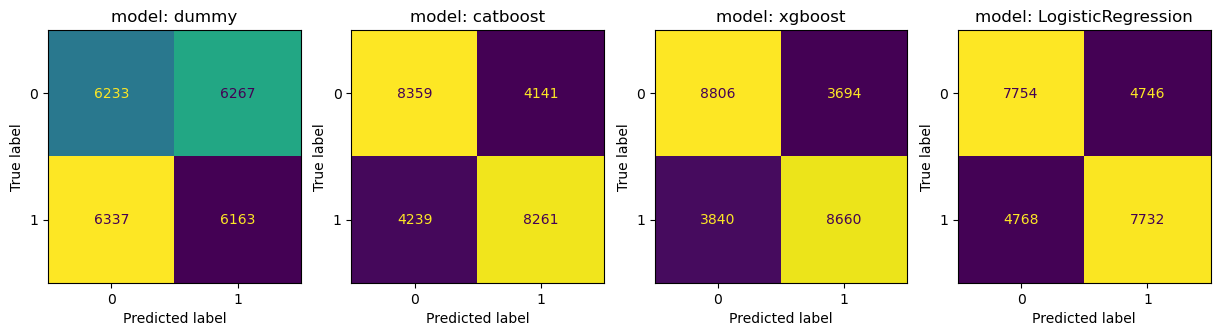

In [26]:
run_models2(X,y1)

In [27]:
# Let's take a classifier giving the best results
xgboost_clf = xgb.XGBClassifier(n_estimators=50, max_depth=5, random_state=0)
xgboost_clf.fit(X,y1)

y_pred = xgboost_clf.predict(X)
accuracy_score(y1, y_pred)

0.69864

In [28]:
len(y_pred)

25000

In [29]:
def predicta(text):
    # del dft
    # text = purify(text)
    dft = pd.DataFrame({'texts':[text]})
    dft['texts_norm'] = dft['texts'].str.lower()
    return xgboost_clf.predict(get_df_topn(dft["texts_norm"], max_features, counter_tokens=cntr).values)[0]
    # return dft

In [30]:
cat=["negative", "positive"]

In [31]:
cat[predicta(df_test.iloc[0]['texts_norm'])]

'negative'

### <span style="color:yellow">Scikit-learn built-in tokenization</span>

In [32]:
vectorizer = CountVectorizer(binary=True, max_features=max_features)
XV = vectorizer.fit_transform(df['texts'])
vectorizer.get_feature_names_out()

array(['about', 'all', 'an', 'and', 'are', 'as', 'at', 'be', 'br', 'but',
       'by', 'can', 'film', 'for', 'from', 'good', 'has', 'have', 'he',
       'his', 'if', 'in', 'is', 'it', 'just', 'like', 'more', 'movie',
       'not', 'of', 'on', 'one', 'or', 'out', 'so', 'some', 'that', 'the',
       'there', 'they', 'this', 'time', 'to', 'up', 'was', 'what', 'when',
       'who', 'with', 'you'], dtype=object)

model=dummy, accuracy=0.49972
model=catboost, accuracy=0.66248
model=xgboost, accuracy=0.69272
model=LogisticRegression, accuracy=0.61552


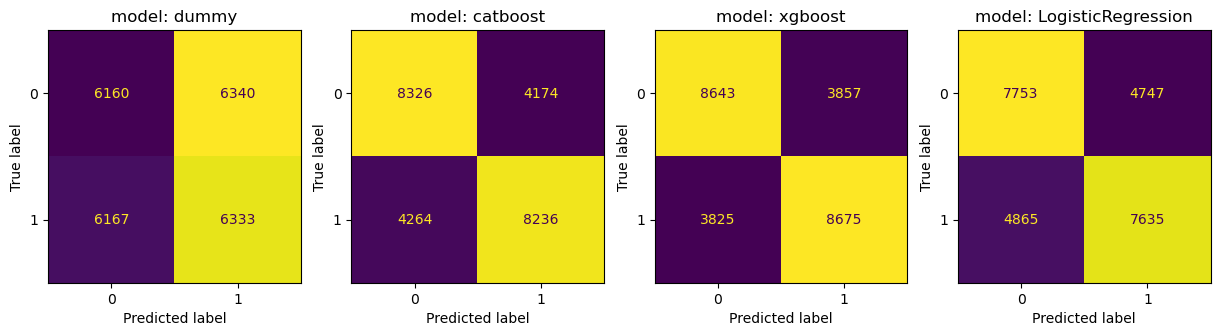

In [33]:
run_models2(XV.toarray(), y1)

In [34]:
# Let's take xgboost once again 
xgboost_clf_v = xgb.XGBClassifier(n_estimators=50, max_depth=5, random_state=0)
xgboost_clf_v.fit(XV.toarray(),y1)
y_pred_v = xgboost_clf_v.predict(XV.toarray())
accuracy_score(y1, y_pred_v)

0.69272

In [35]:
def predictv(text):
    #del dft
    return xgboost_clf_v.predict(vectorizer.transform([text]).toarray())[0]

In [36]:
cat[predictv(df_test.iloc[0]['texts'])]

'negative'

### <span style="color:yellow">Now: A weighted tokenization with TfidfVectorizer (Scikit-learn)</span>

In [37]:
vectorizer = TfidfVectorizer(binary=True, max_features=max_features)
XT = vectorizer.fit_transform(df['texts'])

model=dummy, accuracy=0.49716
model=catboost, accuracy=0.66452
model=xgboost, accuracy=0.71796
model=LogisticRegression, accuracy=0.6154


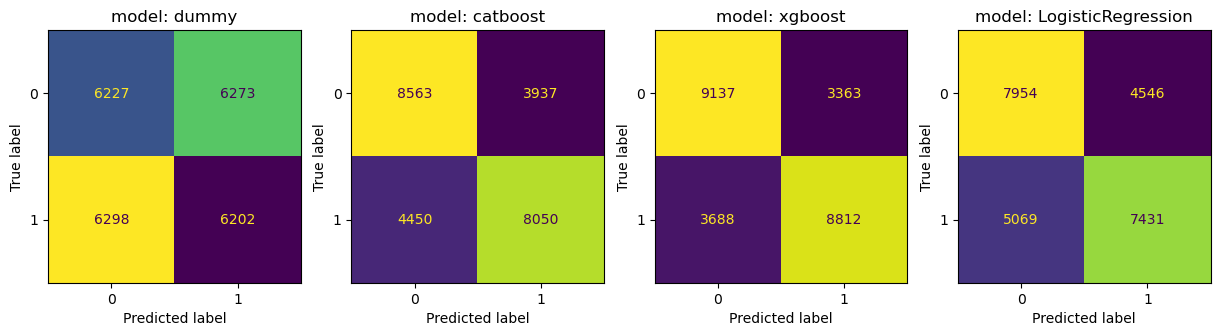

In [38]:
run_models2(XT.toarray(), y1)

In [39]:
# Who is the winner?
xgboost_clf_tfidf = xgb.XGBClassifier(n_estimators=50, max_depth=5, random_state=0)
xgboost_clf_tfidf.fit(XT.toarray(),y1)
y_pred_tfidf = xgboost_clf_tfidf.predict(XT.toarray())
accuracy_score(y1, y_pred_tfidf)

0.71796

In [40]:
def predicttfidf(text):
    return xgboost_clf_tfidf.predict(vectorizer.transform([text]).toarray())[0]

In [41]:
cat[predicttfidf(df_test.iloc[0]['texts'])]

'negative'

# Our own take

In [42]:
!pip install nltk

In [43]:
import re
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter


nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/wsuser/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/wsuser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [44]:
# FULL DATABASE

df1 = pd.read_csv('df.csv')
df2 = pd.read_csv('df_test.csv')

# combine the dataframes into one
df = pd.concat([df1, df2], ignore_index=True)
df = df.sample(frac = 1.0, random_state=33)
del df1, df2

In [45]:
# ONLY TRAINING DATABASE

# df = pd.read_csv('df.csv')
# df = df.sample(frac = 1.0, random_state=33)

### Improvement in the pre-processing of the text

In [46]:
lines = df["texts"].values.tolist()

# Define a function to purify the lines of text
def purify(lines):
    all_reviews = list()
    stop_words = set(stopwords.words("english"))
    stop_words.discard("not")
    print(stop_words)
    for text in lines:
        # Convert the text to lowercase
        text = text.lower()
        
        # Remove URLs from the text
        pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
        text = pattern.sub(' ', text)
        
        # Replace '<br />' with a space
        text = text.replace('<br />', ' ')
        
        # Remove punctuation marks from the text
        text = re.sub(r"[,.\"!@#$%^&*(){}?/;`~:<>+=]", " ", text)
        
        # Tokenize the text into words
        tokens = word_tokenize(text)
        
        # Remove non-alphabetic words
        words = [word for word in tokens if word.isalpha()]
        
        # Remove stop words, excluding the word "not"
        words = [w for w in words if not w in stop_words]
        
        # Join the words back into a single string
        words = ' '.join(words)
        
        # Append the purified text to the list of all reviews
        all_reviews.append(words)
    
    # Return the list of purified reviews
    return all_reviews

df["texts_norm"] = purify(lines)

{'re', 'does', 'couldn', 'hasn', 'on', "you'd", 'doesn', 'there', 'myself', 'have', 'about', 'some', 'a', 'weren', 'aren', 'and', 'if', 'wasn', 'haven', 'hers', 'o', 'll', 'that', 'don', 'whom', 'in', 'up', 'here', 'most', "won't", 'i', "hadn't", "you've", 'didn', "didn't", 'had', 'ma', 'for', 'she', 'ourselves', "wasn't", "doesn't", 'the', "hasn't", 'with', 'when', "that'll", 'is', 'now', 'an', 'of', 't', 'mightn', 'needn', 'ain', "wouldn't", 'herself', 'it', 'itself', 'he', "it's", 'will', 'out', 'once', 'my', "mustn't", 'by', 'through', 'before', 'because', 'off', 'ours', 'having', 'between', 'only', 'd', 'where', 'or', "shouldn't", 'hadn', "isn't", 'any', 'isn', 'these', 'few', "aren't", 'then', 'themselves', "haven't", "weren't", 'our', "you'll", 'until', 'this', 'were', 's', 'yours', 'but', 'at', 'after', 'should', "shan't", 'your', 'against', 'y', 'are', 'm', 'them', 'mustn', 'was', 'being', 'nor', 'did', 'what', "couldn't", 'down', 'can', 'won', 'why', 'theirs', 'all', 'doing',

In [47]:
# tokenization
tokens_set = set()
df['texts_norm'].str.split(" ").map(tokens_set.update)

len(tokens_set)

97631

In [48]:
# what are the most frequent tokens? -> Counter(tokens_set).most_common()
cntr = Counter()
df["texts_norm"].str.split(" ").map(cntr.update)
cntr.most_common(n=5)

[('movie', 86799),
 ('film', 78503),
 ('not', 62533),
 ('one', 52297),
 ('like', 39257)]

In [49]:
def get_df_topn(text: pd.Series, topn: int, counter_tokens: Counter):

    top_tokens = [x[0] for x in counter_tokens.most_common(n=topn)]

    def check_top_n(sent_tokens):
        return [int(token in sent_tokens) for token in top_tokens]

    df_topn = text.str.split(" ").map(set).map(check_top_n).apply(pd.Series) # .apply: If func returns a Series object the result will be a DataFrame.
    df_topn.columns = top_tokens

    return df_topn

In [50]:
df_top50 = get_df_topn(df["texts_norm"], topn=50, counter_tokens=cntr)

df_top50

,movie,film,not,one,like,good,would,even,time,really,...,little,life,ever,better,man,end,scene,still,say,scenes
31809,0,1,1,1,1,0,0,0,0,1,...,0,0,1,0,0,1,1,0,1,1
34702,1,1,1,1,1,1,0,1,1,1,...,0,0,0,0,1,0,0,1,0,1
14222,0,1,1,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
26294,0,1,1,0,1,1,1,0,1,1,...,0,1,0,0,0,0,0,0,1,0
9876,0,1,1,1,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27282,1,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
578,1,0,1,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
38616,1,1,0,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2439,1,1,1,1,1,0,1,0,1,1,...,0,0,0,0,0,1,0,0,1,0


In [51]:
y = df['labels']
y1 = df['labels'].values.tolist()

In [52]:
# We choose a priori 50 as the number of dimensions we will use for classification
# X = get_df_topn( df['texts_norm'], 50, counter_tokens=cntr).values

max_features = 50

X = get_df_topn( df['texts_norm'], max_features, counter_tokens=cntr)
# Replace the special characters in the column names
new_columns = [col.replace('[', '').replace(']', '').replace('<', '') for col in X.columns]

# Rename the columns in the DataFrame
X.rename(columns=dict(zip(X.columns, new_columns)), inplace=True)

#y = (df['target'] == 'spam').astype(np.int8).values
#y = df['labels'].factorize()[0]

In [53]:
def get_models2(use_dummy):
    
    models = [('dummy', DummyClassifier(strategy='stratified'))] if use_dummy else []
    
    models += [
        ('catboost', ctb.CatBoostClassifier(n_estimators=50, max_depth=5, random_state=0, verbose=0)),
        ('xgboost', xgb.XGBClassifier(n_estimators=50, max_depth=5, random_state=0)),
        ('LogisticRegression', LogisticRegression(random_state=0))
    ] 
    return models

In [54]:
def run_models2(X, y, use_dummy=True, scoring='accuracy', plot_result=False, show_confusion_matrix=True):
    result = []
    #cv = StratifiedKFold(n_splits=cv, shuffle=True, random_state=0)
    
    num_cols = 4
    if show_confusion_matrix:
        fig, axes = plt.subplots(nrows=1, ncols=num_cols, figsize=(15,10))


    for it, (model_name, model) in enumerate(get_models2(use_dummy)):
        clf = model
        clf.fit(X,y)
        y_pred = clf.predict(X)
        score = accuracy_score(y, y_pred)
        print("model={}, accuracy={}".format(model_name, score))

        if show_confusion_matrix:
            ax = axes[it]
            disp = ConfusionMatrixDisplay.from_predictions(y,y_pred,ax=ax,colorbar=None)
            disp.ax_.set_title('model: {}'.format(model_name))

model=dummy, accuracy=0.50334
model=catboost, accuracy=0.71958
model=xgboost, accuracy=0.73046
model=LogisticRegression, accuracy=0.70206


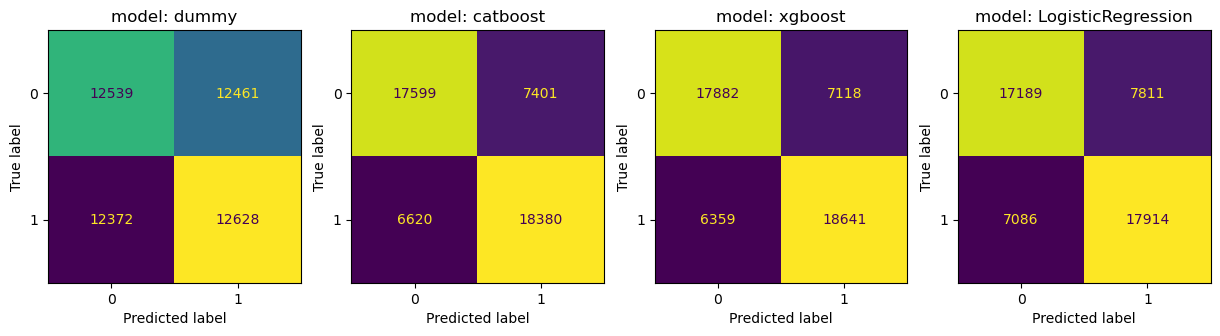

In [55]:
run_models2(X,y1)

### Feature importance of XGBoost

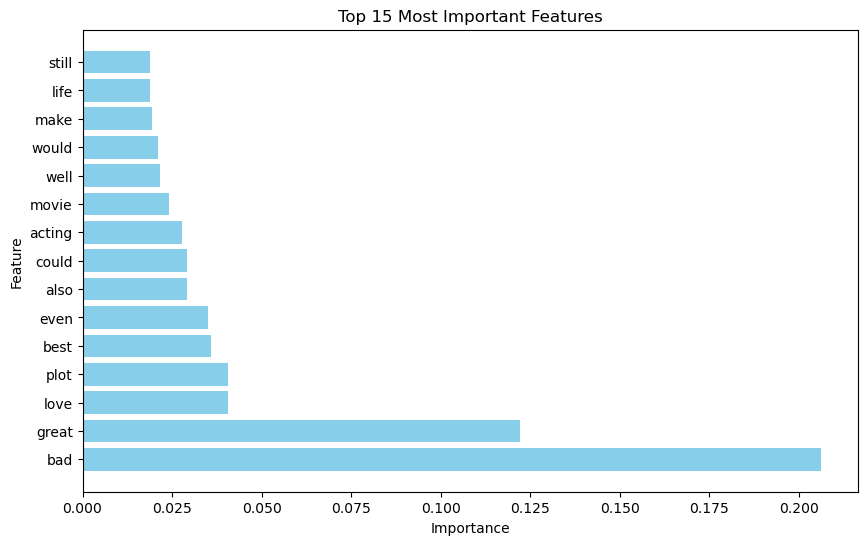

Accuracy: 0.73046
Precision: 0.7236693971039249
Recall: 0.74564
F1-score: 0.7344904351937587


In [56]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize and fit XGBoost classifier
xgboost_clf = xgb.XGBClassifier(n_estimators=50, max_depth=5, random_state=0)
xgboost_clf.fit(X, y1)

# Get feature importances
feature_importance = xgboost_clf.feature_importances_

# Create a DataFrame with feature names and importances
feature_importance_df = pd.DataFrame({'Feature': X.columns,
                                      'Importance': feature_importance})

# Sort the DataFrame by importance values
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Select top N most important features
top_n_features = 15  # Change this value to adjust the number of features shown
top_n_feature_importance_df = feature_importance_df.head(top_n_features)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(top_n_feature_importance_df['Feature'], top_n_feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top {} Most Important Features'.format(top_n_features))
plt.show()

# Calculate and display additional metrics
y_pred = xgboost_clf.predict(X)
accuracy = accuracy_score(y1, y_pred)
precision = precision_score(y1, y_pred)
recall = recall_score(y1, y_pred)
f1 = f1_score(y1, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


In [57]:
catboost_clf = ctb.CatBoostClassifier(n_estimators=50, max_depth=5, random_state=0, verbose=0)
catboost_clf.fit(X,y1)

y_pred = catboost_clf.predict(X)
accuracy_score(y1, y_pred)

0.71958

### Feature importance of CATboost

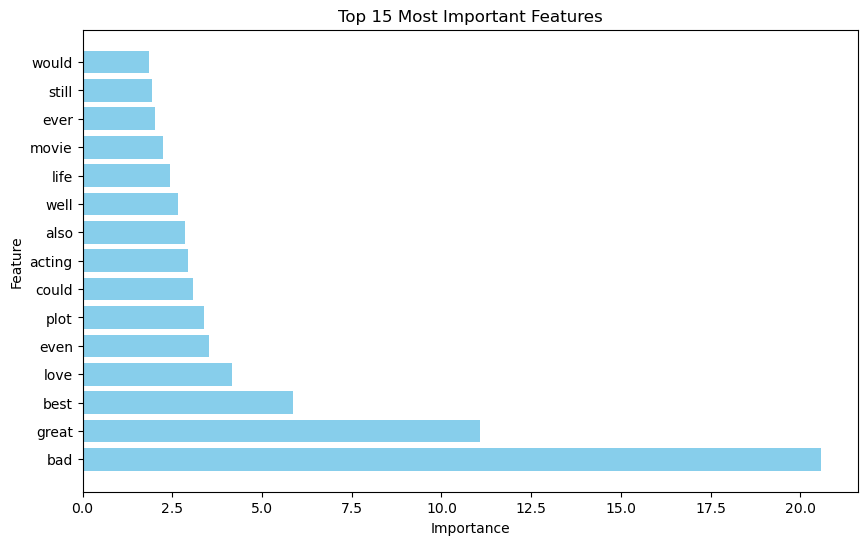

Accuracy: 0.71958
Precision: 0.7129281253636399
Recall: 0.7352
F1-score: 0.7238927945491423


In [58]:
import catboost as ctb
from catboost import Pool
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Convert DataFrame to Pool object
train_pool = Pool(data=X, label=y1)

# Initialize and fit CatBoost classifier using the Pool object
catboost_clf = ctb.CatBoostClassifier(n_estimators=50, max_depth=5, random_state=0, verbose=0)
catboost_clf.fit(train_pool)

# Get feature importances
feature_importance = catboost_clf.get_feature_importance(data=train_pool,
                                                         type='PredictionValuesChange')

# Create a DataFrame with feature names and importances
feature_importance_df = pd.DataFrame({'Feature': X.columns,
                                      'Importance': feature_importance})

# Sort the DataFrame by importance values
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Select top N most important features
top_n_features = 15  # Change this value to adjust the number of features shown
top_n_feature_importance_df = feature_importance_df.head(top_n_features)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(top_n_feature_importance_df['Feature'], top_n_feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top {} Most Important Features'.format(top_n_features))
plt.show()

# Calculate and display additional metrics
y_pred = catboost_clf.predict(train_pool)
accuracy = accuracy_score(y1, y_pred)
precision = precision_score(y1, y_pred)
recall = recall_score(y1, y_pred)
f1 = f1_score(y1, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


In [59]:
len(y_pred)

50000

In [60]:
def predicta(text):
    # del dft
    # text = purify(text)
    dft = pd.DataFrame({'texts':[text]})
    dft['texts_norm'] = dft['texts'].str.lower()
    return xgboost_clf.predict(get_df_topn(dft["texts_norm"], max_features, counter_tokens=cntr).values)[0]
    # return dft

In [61]:
cat=["negative", "positive"]

In [62]:
cat[predicta(df.iloc[0]['texts_norm'])]

'negative'